<a href="https://colab.research.google.com/github/flohmannjr/PJI410/blob/main/PJI410_proje%C3%A7%C3%B5es_de_notifica%C3%A7%C3%B5es.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PJI410 - Projeções (time series) de notificações

# Importações

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import os

import tensorflow as tf

from tensorflow.data import AUTOTUNE, Dataset
from tensorflow.keras import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Add, Bidirectional, Conv1D, Dense, Input, GRU, Lambda, Layer, LSTM, SimpleRNN, Subtract
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

from absl import logging as absl_logging

# Configurações

In [ ]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100

plt.style.use('seaborn-v0_8-darkgrid')

SEMENTE = 2001088 + 2001247 + 2003061 + 2005493 + 2008193 + 2008620 + 2008880

JANELA_TAMANHO_INICIAL = 5
JANELA_TAMANHO_FINAL   = 10  # Não incluído
HORIZONTE_TAMANHO      = 1

CAMINHO_MARCOS = 'marcos'

# Define o nível de log Abseil para 'ERROR'.
# https://abseil.io/docs/python/guides/logging
absl_logging.set_verbosity(absl_logging.ERROR)

## Hiperparâmetros

In [ ]:
LOTE_TAMANHO = 32

CAMADAS = 4

CAMADA_UNIDADES      = 64
CAMADA_INICIALIZADOR = 'he_uniform'
CAMADA_ATIVACAO      = 'relu'

PROFUNDO_POTENCIA_INICIAL = 5
PROFUNDO_POTENCIA_FINAL   = 10  # Não incluída
PROFUNDO_REPETICAO        = 2
PROFUNDO_CONSOLIDACAO     = 32

SAIDA_UNIDADES = 1
SAIDA_ATIVACAO = 'linear'

PERDA       = 'mae'
OTIMIZADOR  = Adam
APRENDIZADO = 0.001
METRICAS    = ['mae', 'mse']

ITERACOES = 1000

## Funções

In [ ]:
!wget https://raw.githubusercontent.com/flohmannjr/PJI410/main/PJI410_funcoes_auxiliares.py

In [ ]:
from PJI410_funcoes_auxiliares import criar_janelas, criar_marco_modelo, grafico_series, metricas_modelo, separar_janelas_treino_teste, set_global_determinism

In [ ]:
def finalizar_modelo(modelo, modelo_nome, janelas_treino, horizontes_treino, janelas_teste, horizontes_teste):

    modelo.compile(loss=PERDA,
                   optimizer=OTIMIZADOR(learning_rate=APRENDIZADO),
                   metrics=METRICAS)

    modelo.fit(x=janelas_treino,
               y=horizontes_treino,
               epochs=ITERACOES,
               batch_size=LOTE_TAMANHO,
               validation_data=(janelas_teste, horizontes_teste),
               callbacks=[ReduceLROnPlateau(monitor='val_loss', patience=100, verbose=0),
                          criar_marco_modelo(modelo_nome, caminho=CAMINHO_MARCOS)],
               verbose=0)

    modelo    = load_model(os.path.join(CAMINHO_MARCOS, modelo_nome))
    previsoes = modelo.predict(janelas_teste, verbose=0)
    metricas  = metricas_modelo(horizontes_teste[:, -1], y_previsao=previsoes[:, -1])

    return modelo, metricas

# Dados

In [ ]:
df_populacao  = pd.read_csv('https://raw.githubusercontent.com/flohmannjr/PJI410/main/dados/PJI410_populacao.csv')
df_municipios = pd.read_csv('https://raw.githubusercontent.com/flohmannjr/PJI410/main/dados/PJI410_municipios.csv')
df_unidades   = pd.read_csv('https://raw.githubusercontent.com/flohmannjr/PJI410/main/dados/PJI410_unidades.csv')

df_notificacoes_por_unidade = pd.read_csv('https://raw.githubusercontent.com/flohmannjr/PJI410/main/dados/PJI410_notificacoes_por_unidade.zip', parse_dates=['Segunda-feira'])
df_notificacoes_por_unidade = df_notificacoes_por_unidade[['UF', 'Municipio', 'Unidade', 'Segunda-feira', 'Quantidade']]
df_notificacoes_por_unidade = df_notificacoes_por_unidade.sort_values(by=['UF', 'Municipio', 'Unidade', 'Segunda-feira']).reset_index(drop=True)

df_notificacoes_por_municipio = df_notificacoes_por_unidade[['UF', 'Municipio', 'Segunda-feira', 'Quantidade']].groupby(by=['UF', 'Municipio', 'Segunda-feira']).sum()
df_notificacoes_por_municipio = df_notificacoes_por_municipio.sort_index().reset_index()

df_notificacoes_por_uf = df_notificacoes_por_unidade[['UF', 'Segunda-feira', 'Quantidade']].groupby(by=['UF', 'Segunda-feira']).sum()
df_notificacoes_por_uf = df_notificacoes_por_uf.sort_index().reset_index()

df_notificacoes_por_semana = df_notificacoes_por_unidade[['Segunda-feira', 'Quantidade']].groupby(by=['Segunda-feira']).sum()
df_notificacoes_por_semana = df_notificacoes_por_semana.sort_index().reset_index()

In [ ]:
dados = df_notificacoes_por_semana
q_treino = int(len(dados) * 0.8)

quantidades = dados['Quantidade'].to_numpy().astype('float32')

In [ ]:
X_train = dados[:q_treino]['Segunda-feira'].to_numpy()
y_train = dados[:q_treino]['Quantidade'].to_numpy()

X_test = dados[q_treino:]['Segunda-feira'].to_numpy()
y_test = dados[q_treino:]['Quantidade'].to_numpy()

In [ ]:
len(quantidades), len(X_train), len(y_train), len(X_test), len(y_test)

# Modelos

In [ ]:
modelos  = [None] * 50
metricas = [None] * 50

MODELO_NUMERO = 0

## Modelo Ingênuo

Naïve method: https://otexts.com/fpp3/simple-methods.html#na%C3%AFve-method

Para previsões ingênuas, simplesmente definimos todas as previsões como o valor da observação anterior.

In [ ]:
y_pred = y_test[:-1]

In [ ]:
grafico_series(X_teste=X_test[1:], y_teste=y_test[1:],
               X_previsao=X_test[1:], y_previsao=y_pred)

In [ ]:
metricas[MODELO_NUMERO] = metricas_modelo(y_test[1:], y_pred)

print(metricas[MODELO_NUMERO])

MODELO_NUMERO += 1

## Modelos Densos

In [ ]:
%%time

set_global_determinism(seed=SEMENTE)

for janela_tamanho in range(JANELA_TAMANHO_INICIAL, JANELA_TAMANHO_FINAL):

    janelas, horizontes = criar_janelas(quantidades, janela_tamanho, HORIZONTE_TAMANHO)

    janelas_treino, janelas_teste, horizontes_treino, horizontes_teste = separar_janelas_treino_teste(janelas, horizontes, tamanho_teste=0.2)

    modelo_nome = f'modelo_{MODELO_NUMERO}_denso_{janela_tamanho}j_{HORIZONTE_TAMANHO}h'

    modelos[MODELO_NUMERO] = Sequential(name=modelo_nome)

    for c in range(CAMADAS):
        modelos[MODELO_NUMERO].add(Dense(units=CAMADA_UNIDADES, kernel_initializer=CAMADA_INICIALIZADOR, activation=CAMADA_ATIVACAO, name=f'camada_oculta_{c}'))

    modelos[MODELO_NUMERO].add(Dense(units=horizonte_tamanho, activation=SAIDA_ATIVACAO, name='camada_saida'))
    
    modelos[MODELO_NUMERO], metricas[MODELO_NUMERO] = finalizar_modelo(modelos[MODELO_NUMERO], modelo_nome, janelas_treino, horizontes_treino, janelas_teste, horizontes_teste)

    print(modelo_nome)
    print(metricas[MODELO_NUMERO])
    print()

    MODELO_NUMERO += 1

In [ ]:
# grafico_series(X_teste=X_test[-len(janelas_teste):], y_teste=horizontes_teste[:, -1],
#                X_previsao=X_test[-len(janelas_teste):], y_previsao=previsoes[:, -1])

## Modelos Densos Profundos

In [ ]:
%%time

set_global_determinism(seed=SEMENTE)

for janela_tamanho in range(JANELA_TAMANHO_INICIAL, JANELA_TAMANHO_FINAL):

    janelas, horizontes = criar_janelas(quantidades, janela_tamanho, HORIZONTE_TAMANHO)

    janelas_treino, janelas_teste, horizontes_treino, horizontes_teste = separar_janelas_treino_teste(janelas, horizontes, tamanho_teste=0.2)

    modelo_nome = f'modelo_{MODELO_NUMERO}_denso_profundo_{janela_tamanho}j_{HORIZONTE_TAMANHO}h'

    modelos[MODELO_NUMERO] = Sequential(name=modelo_nome)

    for potencia in range(PROFUNDO_POTENCIA_INICIAL, PROFUNDO_POTENCIA_FINAL):
        unidades = 2 ** potencia
        for r in range(PROFUNDO_REPETICAO):
            modelos[MODELO_NUMERO].add(Dense(units=unidades, kernel_initializer=CAMADA_INICIALIZADOR, activation=CAMADA_ATIVACAO, name=f'camada_oculta_{unidades}_{r}'))

    modelos[MODELO_NUMERO].add(Dense(units=PROFUNDO_CONSOLIDACAO, activation=CAMADA_ATIVACAO, name='camada_consolidacao'))
    modelos[MODELO_NUMERO].add(Dense(units=horizonte_tamanho, activation=SAIDA_ATIVACAO, name='camada_saida'))
    
    modelos[MODELO_NUMERO], metricas[MODELO_NUMERO] = finalizar_modelo(modelos[MODELO_NUMERO], modelo_nome, janelas_treino, horizontes_treino, janelas_teste, horizontes_teste)

    print(modelo_nome)
    print(metricas[MODELO_NUMERO])
    print()

    MODELO_NUMERO += 1

In [ ]:
# grafico_series(X_teste=X_test[-len(janelas_teste):], y_teste=horizontes_teste[:, -1],
#                X_previsao=X_test[-len(janelas_teste):], y_previsao=previsoes[:, -1])

## Modelos Convulacionais

In [ ]:
%%time

set_global_determinism(seed=SEMENTE)

for janela_tamanho in range(JANELA_TAMANHO_INICIAL, JANELA_TAMANHO_FINAL):

    janelas, horizontes = criar_janelas(quantidades, janela_tamanho, HORIZONTE_TAMANHO)

    janelas_treino, janelas_teste, horizontes_treino, horizontes_teste = separar_janelas_treino_teste(janelas, horizontes, tamanho_teste=0.2)

    modelo_nome = f'modelo_{MODELO_NUMERO}_convulacional_{janela_tamanho}j_{HORIZONTE_TAMANHO}h'

    modelos[MODELO_NUMERO] = Sequential(name=modelo_nome)

    modelos[MODELO_NUMERO].add(Lambda(lambda x: tf.expand_dims(x, axis=1), name='camada_lambda'))  # Adiciona uma dimensão aos dados.

    modelos[MODELO_NUMERO].add(Conv1D(filters=CAMADA_UNIDADES,
                                      kernel_size=janela_tamanho,
                                      kernel_initializer=CAMADA_INICIALIZADOR,
                                      padding='causal',
                                      activation=CAMADA_ATIVACAO,
                                      name='camada_convulacional'))

    modelos[MODELO_NUMERO].add(Dense(units=horizonte_tamanho, activation=SAIDA_ATIVACAO, name='camada_saida'))
    
    modelos[MODELO_NUMERO], metricas[MODELO_NUMERO] = finalizar_modelo(modelos[MODELO_NUMERO], modelo_nome, janelas_treino, horizontes_treino, janelas_teste, horizontes_teste)

    print(modelo_nome)
    print(metricas[MODELO_NUMERO])
    print()

    MODELO_NUMERO += 1

In [ ]:
# grafico_series(X_teste=X_test[-len(janelas_teste):], y_teste=tf.squeeze(horizontes_teste),
#                X_previsao=X_test[-len(janelas_teste):], y_previsao=tf.squeeze(previsoes))

## Modelos Recorrentes

In [ ]:
%%time

set_global_determinism(seed=SEMENTE)

recorrentes = {'rnn_simples': 'SimpleRNN', 'lstm': 'LSTM', 'gru': 'GRU'}

for nome, funcao in recorrentes.items():

    for janela_tamanho in range(JANELA_TAMANHO_INICIAL, JANELA_TAMANHO_FINAL):

        janelas, horizontes = criar_janelas(quantidades, janela_tamanho, HORIZONTE_TAMANHO)

        janelas_treino, janelas_teste, horizontes_treino, horizontes_teste = separar_janelas_treino_teste(janelas, horizontes, tamanho_teste=0.2)

        modelo_nome = f'modelo_{MODELO_NUMERO}_{nome}_{janela_tamanho}j_{HORIZONTE_TAMANHO}h'

        modelos[MODELO_NUMERO] = Sequential(name=modelo_nome)

        modelos[MODELO_NUMERO].add(Lambda(lambda x: tf.expand_dims(x, axis=1), name='camada_lambda'))

        modelos[MODELO_NUMERO].add(funcao(units=CAMADA_UNIDADES,
                                          kernel_initializer=CAMADA_INICIALIZADOR,
                                          activation=CAMADA_ATIVACAO,  # Ativação 'relu' no lugar de 'tanh' por motivo de performance.
                                          name=f'camada_{nome}'))

        modelos[MODELO_NUMERO].add(Dense(units=CAMADA_UNIDADES, activation=CAMADA_ATIVACAO, name='camada_consolidacao'))
        modelos[MODELO_NUMERO].add(Dense(units=horizonte_tamanho, activation=SAIDA_ATIVACAO, name='camada_saida'))
        
        modelos[MODELO_NUMERO], metricas[MODELO_NUMERO] = finalizar_modelo(modelos[MODELO_NUMERO], modelo_nome, janelas_treino, horizontes_treino, janelas_teste, horizontes_teste)

        print(modelo_nome)
        print(metricas[MODELO_NUMERO])
        print()

        MODELO_NUMERO += 1

In [ ]:
# grafico_series(X_teste=X_test[-len(janelas_teste):], y_teste=tf.squeeze(horizontes_teste),
#                X_previsao=X_test[-len(janelas_teste):], y_previsao=tf.squeeze(previsoes))

## Modelos N-BEATS

N-BEATS: Neural basis expansion analysis for interpretable time series forecasting https://arxiv.org/abs/1905.10437

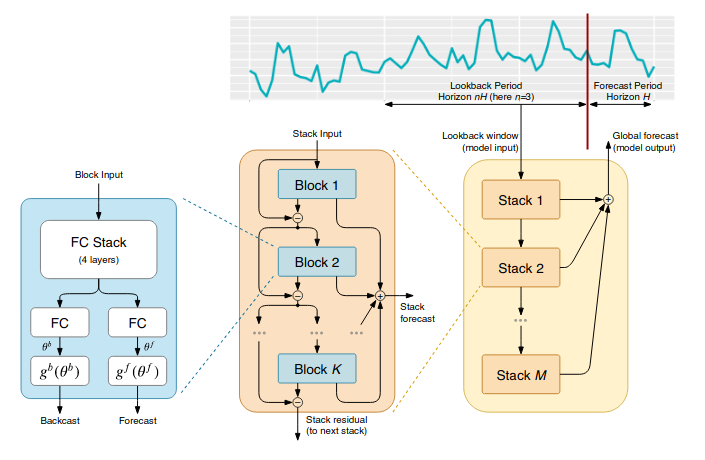

(Do artigo) **Figure 1: Proposed architecture**. The basic building block is a multi-layer Fully Connected (FC) network with ReLU nonlinearities. It predicts basis expansion coefficients both forward, $\theta^f$ (forecast), and backward, $\theta^b$ (backcast). Blocks are organized into stacks using doubly residual stacking principle. A stack may have layers with shared $g^b$ and $g^f$. Forecasts are aggregated in hierarchical fashion. This enables building a very deep neural network with interpretable outputs.


Making new Layers and Models via subclassing https://www.tensorflow.org/guide/keras/custom_layers_and_models

De acordo com o [código fonte](https://github.com/tensorflow/tensorflow/blob/fcc4b966f1265f466e82617020af93670141b009/tensorflow/python/keras/engine/base_layer.py#L308-L316) (em 08.03.2023), os kwargs permitidos pela classe `Layer` são: `input_dim`, `input_shape`, `batch_input_shape`, `batch_size`, `weights`, `activity_regularizer` e `autocast`. Além destes, `Layer` possui os argumentos `trainable`, `name`, `dtype` e `dynamic`.

In [ ]:
# A seção 3 do artigo descreve a arquitetura do modelo.
# Para este modelo foi utilizada a arquitetura genérica, descrita na seção 3.3, que não utiliza conhecimentos específicos de séries temporais.

class NBeatsBlock(Layer):

    def __init__(self,
                 input_size: int,
                 horizon: int,
                 n_neurons: int,
                 **kwargs):

        super().__init__(**kwargs)

        self.input_size = input_size  # Tamanho da entrada.
        self.horizon    = horizon     # Tamanho da saída.
        self.n_neurons  = n_neurons   # Quantidade de neurônios.

        self.theta_size = input_size + horizon  # Tamanho do coeficiente de expansão.

        self.hidden      = [Dense(units=n_neurons, activation='relu') for _ in range(4)]  # Camadas densas (FC) ReLU (x4).
        self.theta_layer = Dense(units=self.theta_size, activation='linear')              # Camada theta linear, para backcast e forecast.

    def call(self, inputs):

        x = inputs

        for layer in self.hidden:
            x = layer(x)

        theta = self.theta_layer(x)

        backcast = theta[:, :self.input_size]
        forecast = theta[:, -self.horizon:]

        return backcast, forecast

In [ ]:
# Hiperparâmetros (Tabela 18)

NBEATS_ITERACOES = 5000
NBEATS_NEURONIOS = 512
NBEATS_PILHAS    = 30
NBEATS_LOTE      = 1024
NBEATS_ENTRADA   = janela_tamanho * HORIZONTE_TAMANHO
NBEATS_HORIZONTE = HORIZONTE_TAMANHO

In [ ]:
%%time

set_global_determinism(seed=SEMENTE)

for janela_tamanho in range(JANELA_TAMANHO_INICIAL, JANELA_TAMANHO_FINAL):

    janelas, horizontes = criar_janelas(quantidades, janela_tamanho, HORIZONTE_TAMANHO)

    janelas_treino, janelas_teste, horizontes_treino, horizontes_teste = separar_janelas_treino_teste(janelas, horizontes, tamanho_teste=0.2)

    dataset_janelas_treino    = Dataset.from_tensor_slices(janelas_treino)
    dataset_janelas_teste     = Dataset.from_tensor_slices(janelas_teste)
    dataset_horizontes_treino = Dataset.from_tensor_slices(horizontes_treino)
    dataset_horizontes_teste  = Dataset.from_tensor_slices(horizontes_teste)

    dataset_treino = Dataset.zip((dataset_janelas_treino, dataset_horizontes_treino))
    dataset_teste  = Dataset.zip((dataset_janelas_teste, dataset_horizontes_teste))

    dataset_treino = dataset_treino.batch(NBEATS_LOTE).prefetch(AUTOTUNE)
    dataset_teste  = dataset_teste.batch(NBEATS_LOTE).prefetch(AUTOTUNE)

    modelo_nome = f'modelo_{MODELO_NUMERO}_nbeats_{janela_tamanho}j_{HORIZONTE_TAMANHO}h'

    entradas = Input(shape=(NBEATS_ENTRADA), name='camada_entrada')

    residuo, previsao = NBeatsBlock(input_size=NBEATS_ENTRADA,
                                    horizon=NBEATS_HORIZONTE,
                                    n_neurons=NBEATS_NEURONIOS,
                                    name='bloco_0')(entradas)

    for p in range(1, NBEATS_PILHAS):

        residuo_pilha, previsao_pilha = NBeatsBlock(input_size=NBEATS_ENTRADA,
                                                    horizon=NBEATS_HORIZONTE,
                                                    n_neurons=NBEATS_NEURONIOS,
                                                    name=f'bloco_{p}')(residuo)

        residuo  = Subtract(name=f"subtracao_{p}")([residuo, residuo_pilha])
        previsao = Add(name=f"adicao_{p}")([previsao, previsao_pilha])

    modelos[MODELO_NUMERO] = Model(inputs=entradas, outputs=previsao, name=modelo_nome)
    
    modelos[MODELO_NUMERO].compile(loss=PERDA,
                                   optimizer=OTIMIZADOR(learning_rate=APRENDIZADO),
                                   metrics=METRICAS)

    modelos[MODELO_NUMERO].fit(dataset_treino,
                               epochs=NBEATS_ITERACOES,
                               validation_data=dataset_teste,
                               callbacks=[EarlyStopping(monitor='val_loss', patience=200, restore_best_weights=True),
                                          ReduceLROnPlateau(monitor='val_loss', patience=100, verbose=0),
                                          criar_marco_modelo(modelo_nome, caminho=CAMINHO_MARCOS)],
                               verbose=0)

    modelos[MODELO_NUMERO] = load_model(os.path.join(CAMINHO_MARCOS, modelo_nome))

    previsoes = modelos[MODELO_NUMERO].predict(dataset_teste, verbose=0)

    metricas[MODELO_NUMERO] = metricas_modelo(tf.squeeze(horizontes_teste), y_previsao=tf.squeeze(previsoes))

    print(modelo_nome)
    print(metricas[MODELO_NUMERO])
    print()

    MODELO_NUMERO += 1

In [ ]:
# grafico_series(X_teste=X_test[-len(janelas_teste):], y_teste=tf.squeeze(horizontes_teste),
#                X_previsao=X_test[-len(janelas_teste):], y_previsao=tf.squeeze(previsoes))

## Comparação dos modelos

In [ ]:
df_metricas = pd.DataFrame([m for m in metricas if m is not None])

with pd.option_context('display.max_columns', None):
    display(df_metricas.T)

In [ ]:
df_metricas['Mean Absolute Error'].sort_values()